#### Imports 

In [1]:
import numpy as np
import re 
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

%matplotlib inline

### The Project at First Glance

    The goal of this project is to analyze what we know about COVID-19's statistical significance, as well as conduct a forecast analysis to predict the severity of COVID-19 as we approach the Winter season. Could there be another arduous wave of COVID-19 through Winter? If so, how detrimental may it be toward our efforts to flatten the curve?
    
    
#### Null Hypothesis: COVID-19 Deaths are not associated with active cases, and rather attributed to other causes 
#### Hypothesis : COVID-19 Deaths are associated with active cases 


    
- Dataset - https://raw.githubusercontent.com/CSSEGISandData/COVID-19/ (Johns Hopkins CSSEGIS, Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE))

# Part 1 : Data Retrieval & Cleaning

I started by gathering data for all confirmed cases of COVID-19 to date, and cleaned it up to be versatile for later steps. Separation of cases in a heirarchy is my next step, where I will retrieve data for confirmed fatalities due to COVID-19, recoveries, and remaining active confirmed cases that are inconclusive. 

#### *Subset 1 - Confirmed Cases of COVID-19*

In [122]:
COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)

covid_confirmed['Province/State'].fillna('', inplace=True)
covid_confirmed['Country/Region'].fillna('', inplace=True)

covid_confirmed.info() 
covid_confirmed.isna().sum().sum()
covid_confirmed.head(5)

covid_confirmed.to_csv('covid_confirmed.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 181 entries, Province/State to 7/16/20
dtypes: float64(2), int64(177), object(2)
memory usage: 376.3+ KB


#### *Subset 2 - Confirmed Deaths Due to COVID-19*

In [123]:
COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

covid_deaths = pd.read_csv(COVID_DEATHS_URL)

covid_deaths['Province/State'].fillna('', inplace=True)
covid_deaths['Country/Region'].fillna('', inplace=True)

covid_deaths.info()
covid_deaths.isna().sum().sum()
covid_deaths.head(5)

covid_deaths.to_csv('covid_deaths.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 181 entries, Province/State to 7/16/20
dtypes: float64(2), int64(177), object(2)
memory usage: 376.3+ KB


#### *Subset 3 - Confirmed Recoveries from COVID-19*

In [124]:
COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_recovered['Province/State'].fillna('', inplace=True)
covid_recovered['Country/Region'].fillna('', inplace=True)

covid_recovered.info()
covid_recovered.isna().sum().sum()
covid_recovered.head(1)

covid_recovered.to_csv('covid_recovered.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Columns: 181 entries, Province/State to 7/16/20
dtypes: float64(2), int64(177), object(2)
memory usage: 357.9+ KB


# Part 2 - Time Series Data Analysis

Within the next portion of this exploratory data analysis, my goal was to take a granular approach for complete understanding of the data. I conducted a time series data analysis of all countries with some feature engineering to show the regression pattern for each of the following: 

+ Confirmed Case Total by Month to Date
+ Confirmed Deaths Total by Month to Date
+ Confirmed Recoveries Total by Month to Date
+ Confirmed Active (Inconclusive) Cases by Month to Date 


#### Time Series Analysis : Confirmed Case Total by Month to Date 
+ Time series data analysis for confirmed cases of COVID-19

## 1 - Confirmed Cases 

#### MAX CONFIRMED CASES IN A GIVEN MONTH

In [125]:
covid_confirmed_raw = covid_confirmed.loc[:, '1/22/20':]
covid_confirmed_count = covid_confirmed_raw.sum().max()
covid_confirmed_raw.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20
0,0,0,0,0,0,0,0,0,0,0,...,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070
1,0,0,0,0,0,0,0,0,0,0,...,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851
2,0,0,0,0,0,0,0,0,0,0,...,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355
3,0,0,0,0,0,0,0,0,0,0,...,855,855,855,855,855,855,858,861,862,877
4,0,0,0,0,0,0,0,0,0,0,...,386,386,396,458,462,506,525,541,576,607


In [126]:
raw_confirmed_cases_ts = covid_confirmed.iloc[:, 4:].sum(axis=0)

raw_confirmed_cases_ts

1/22/20         555
1/23/20         654
1/24/20         941
1/25/20        1434
1/26/20        2118
             ...   
7/12/20    12910357
7/13/20    13104391
7/14/20    13324057
7/15/20    13555532
7/16/20    13805296
Length: 177, dtype: int64

In [127]:
covid_confirmed_count

13805296

<Figure size 576x396 with 0 Axes>

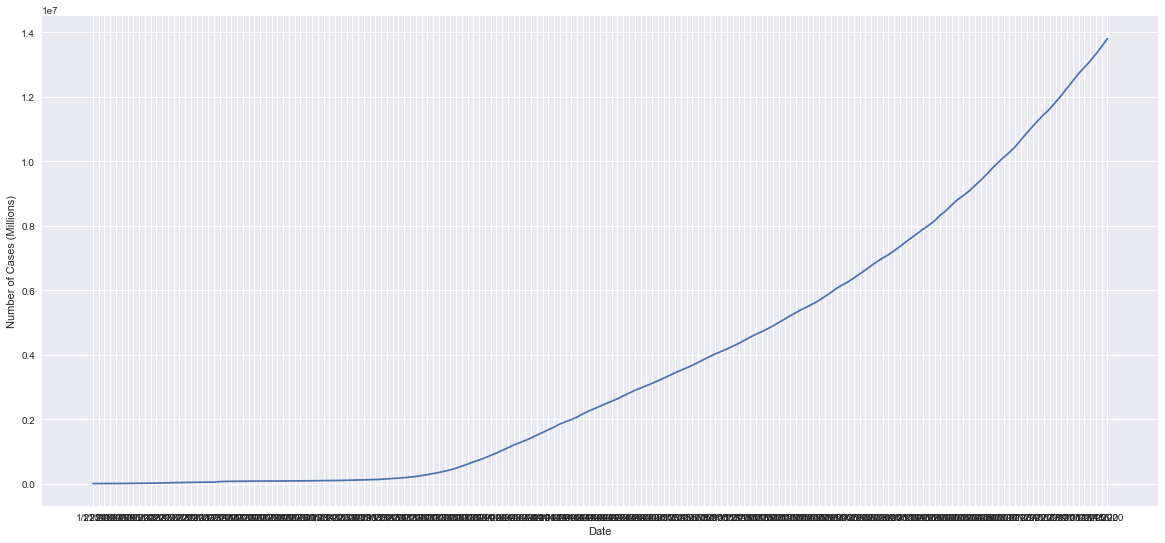

In [128]:
# Building time series plot # 

## Styling ## 
plt.style.use('seaborn')
plt.tight_layout()

plt.figure(figsize=(20,10))
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Number of Cases (Millions)')

## Plot ##
plt.plot(raw_confirmed_cases_ts, linestyle='solid')
plt.show()


### 2 - Confirmed Deaths

#### MAX CONFIRMED DEATHS IN A GIVEN MONTH


In [129]:
raw_confirmed_deaths_ts = covid_deaths.loc[:, '1/22/20':]
covid_deaths_count = raw_confirmed_deaths_ts.sum().max()
raw_confirmed_deaths_ts.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20
0,0,0,0,0,0,0,0,0,0,0,...,920,936,957,971,994,1010,1012,1048,1094,1113
1,0,0,0,0,0,0,0,0,0,0,...,81,83,83,85,89,93,95,97,101,104
2,0,0,0,0,0,0,0,0,0,0,...,968,978,988,996,1004,1011,1018,1028,1040,1052
3,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52
4,0,0,0,0,0,0,0,0,0,0,...,21,21,22,23,23,26,26,26,27,28


In [130]:
raw_confirmed_deaths_ts = covid_deaths.iloc[:, 4:].sum(axis=0)

raw_confirmed_deaths_ts

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
7/12/20    569128
7/13/20    573003
7/14/20    578646
7/15/20    584132
7/16/20    589911
Length: 177, dtype: int64

In [131]:
covid_deaths_count

589911

<Figure size 576x396 with 0 Axes>

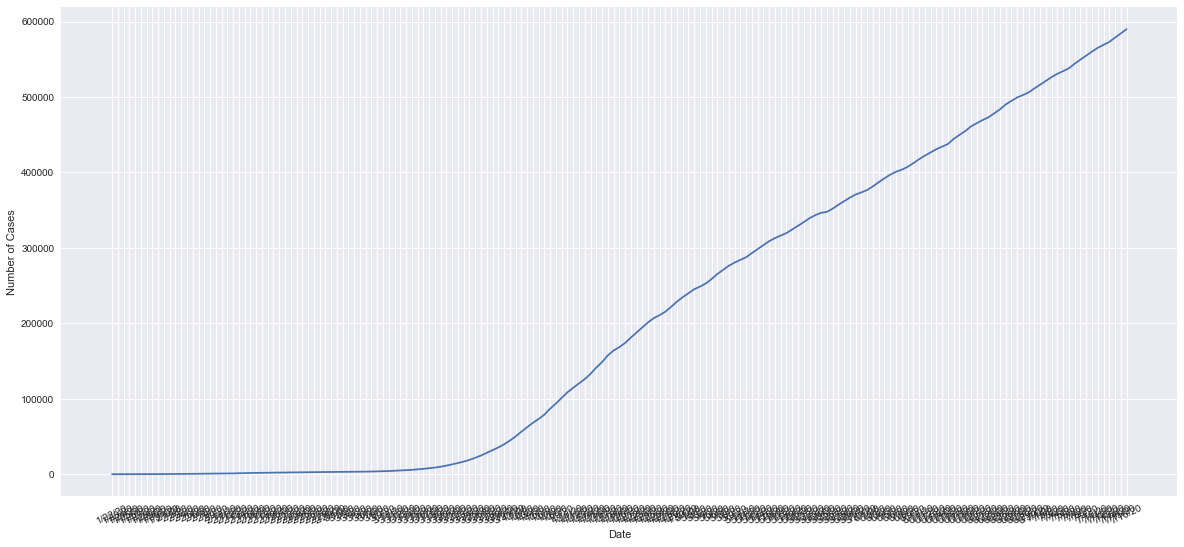

In [132]:
# Building time series plot # 

## Styling ## 
plt.style.use('seaborn')
plt.tight_layout()

plt.figure(figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=25)

## Plot ## 
plt.plot(raw_confirmed_deaths_ts, linestyle='solid')
plt.show()


### 3 - Confirmed Recoveries

#### MAX CONFIRMED RECOVERIES IN A GIVEN MONTH

In [133]:
raw_confirmed_recoveries_ts = covid_recovered.loc[:, '1/22/20':]
covid_recovered_count = raw_confirmed_recoveries_ts.sum().max()
raw_confirmed_recoveries_ts.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20
0,0,0,0,0,0,0,0,0,0,0,...,20179,20700,20847,20882,21135,21216,21254,21454,22456,22824
1,0,0,0,0,0,0,0,0,0,0,...,1744,1791,1832,1875,1881,1946,2014,2062,2091,2137
2,0,0,0,0,0,0,0,0,0,0,...,12094,12329,12637,13124,13124,13743,14019,14295,14792,15107
3,0,0,0,0,0,0,0,0,0,0,...,800,802,802,803,803,803,803,803,803,803
4,0,0,0,0,0,0,0,0,0,0,...,117,117,117,117,118,118,118,118,124,124


In [134]:
raw_confirmed_recoveries_ts = covid_recovered.iloc[:, 4:].sum(axis=0)

raw_confirmed_recoveries_ts

1/22/20         28
1/23/20         30
1/24/20         36
1/25/20         39
1/26/20         52
            ...   
7/12/20    7116957
7/13/20    7257369
7/14/20    7399474
7/15/20    7559252
7/16/20    7711525
Length: 177, dtype: int64

In [135]:
covid_recovered_count

7711525

<Figure size 576x396 with 0 Axes>

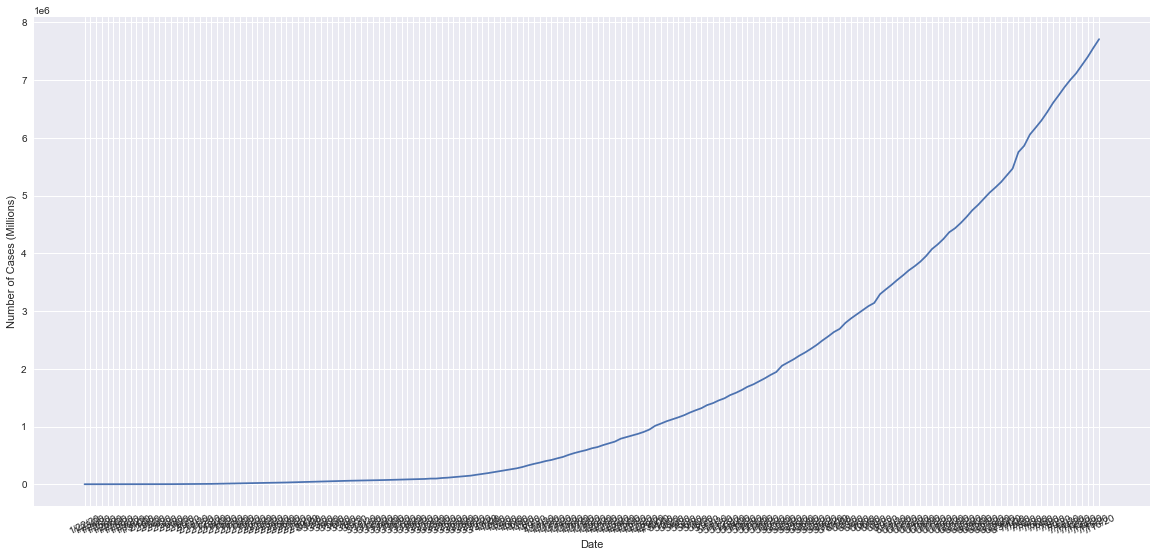

In [136]:
# Building time series plot # 

## Styling ## 
plt.style.use('seaborn')
plt.tight_layout()

plt.figure(figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of Cases (Millions)')
plt.xticks(rotation=25)

## Plot ## 
plt.plot(raw_confirmed_recoveries_ts, linestyle='solid')
plt.show()


In [137]:
covid_recovered_count

7711525

## 4 - Active (Inconclusive) Cases 

In [138]:
raw_confirmed_active_ts = raw_confirmed_cases_ts - raw_confirmed_deaths_ts - raw_confirmed_recoveries_ts

raw_confirmed_active_ts.head()

1/22/20     510
1/23/20     606
1/24/20     879
1/25/20    1353
1/26/20    2010
dtype: int64

In [139]:
covid_active_count = covid_confirmed_count - covid_deaths_count - covid_recovered_count
covid_active_count

5503860

<Figure size 576x396 with 0 Axes>

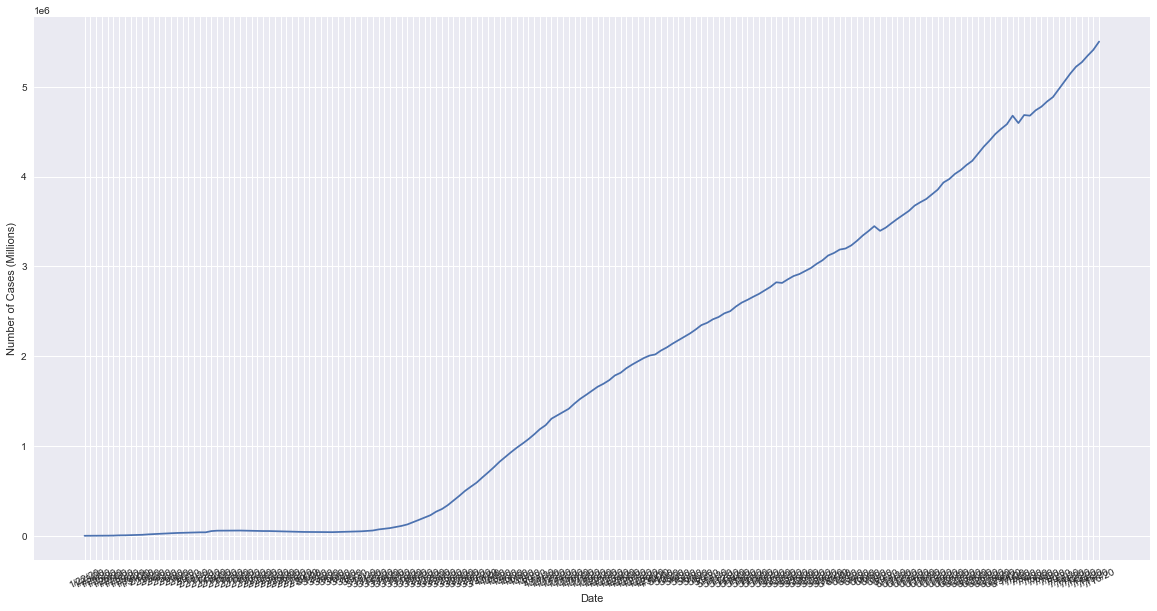

In [140]:
# Building time series plot # 

## Styling ## 
plt.style.use('seaborn')
plt.tight_layout()

## Graph Constraints ## 
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Number of Cases (Millions)')
plt.xticks(rotation=25)

## Plot ## 

plt.plot(raw_confirmed_active_ts, linestyle='solid')

plt.show()

In [141]:
# Creating a dataframe summarizing confirmed cases and those that are still active, awaiting conclusion
raw_confirmed_active_ts = [covid_confirmed_count - covid_deaths_count - covid_recovered_count]
world_df = pd.DataFrame({
    'confirmed': [covid_confirmed_count],
    'deaths': [covid_deaths_count],
    'recovered': [covid_recovered_count],
    'active': raw_confirmed_active_ts
})

world_df

,confirmed,deaths,recovered,active
0,13805296,589911,7711525,5503860


In [142]:
# Creating a dataframe summarizing max confirmed cases and their statuses

world_long_df = world_df.melt(value_vars=['active', 'deaths', 'recovered'],
                              var_name="status",
                              value_name="count")

world_long_df['upper'] = 'confirmed'

world_long_df

,status,count,upper
0,active,5503860,confirmed
1,deaths,589911,confirmed
2,recovered,7711525,confirmed


# Part 3. Summarizing Our Findings 

## Time Series Plots

In summary, we compile the total case counts and observe the logarithmic and linear patterns among confirmed cases, deaths, recoveries, and active (inconclusive) cases. 

In [143]:
covid_worldwide_confirmed = covid_confirmed.iloc[:, 4:].sum(axis=0)

covid_worldwide_confirmed.head()
covid_worldwide_deaths = covid_deaths.iloc[:, 4:].sum(axis=0)

covid_worldwide_deaths.head()
covid_worldwide_recovered = covid_recovered.iloc[:, 4:].sum(axis=0)

covid_worldwide_recovered.head()

1/22/20    28
1/23/20    30
1/24/20    36
1/25/20    39
1/26/20    52
dtype: int64

In [144]:
covid_worldwide_active = covid_worldwide_confirmed - covid_worldwide_deaths - covid_worldwide_recovered

covid_worldwide_active.head()

1/22/20     510
1/23/20     606
1/24/20     879
1/25/20    1353
1/26/20    2010
dtype: int64

## Logarithmic Scale (Cases Over Time)

Here, we can see that the dips in each line have a direct correlation. Confirmed cases drop at a similar rate to active cases, while recoveries increase as a result. This is constituted by the larger drop in deaths prior to March, where lockdowns and heightened CDC protocol were established. From then on, the active (inconclusive) cases flattened while confirmed cases and recoveries rose. Deaths began to flatten as well. 

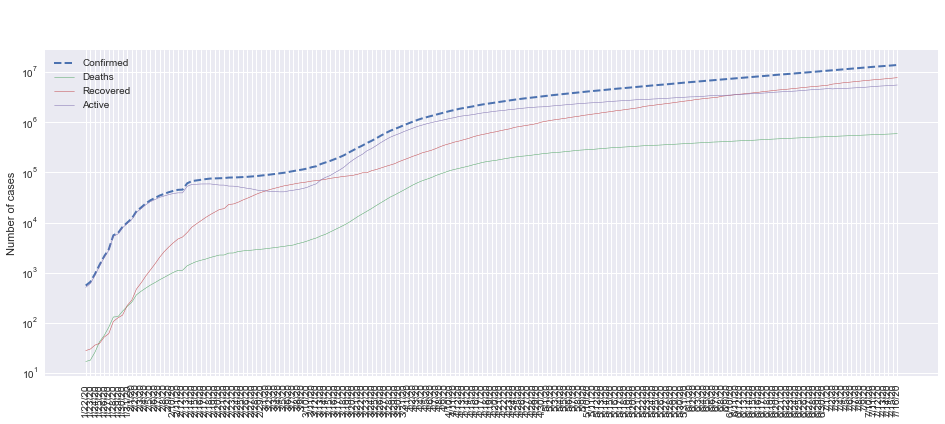

In [145]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set(yscale="log")

sns.lineplot(x=covid_worldwide_confirmed.index, y=covid_worldwide_confirmed, sort=False, linewidth=2)
sns.lineplot(x=covid_worldwide_deaths.index, y=covid_worldwide_deaths, sort=False, linewidth=.5)
sns.lineplot(x=covid_worldwide_recovered.index, y=covid_worldwide_recovered, sort=False, linewidth=.5)
sns.lineplot(x=covid_worldwide_active.index, y=covid_worldwide_active, sort=False, linewidth=.5)

ax.lines[0].set_linestyle("--")
plt.suptitle("COVID-19 worldwide cases over the time", fontsize=16, fontweight='bold', color='white')
plt.title("(logarithmic scale)", color='white')

plt.xticks(rotation=90)
plt.ylabel('Number of cases')

ax.legend(['Confirmed', 'Deaths', 'Recovered', 'Active'])

plt.show()

## Linear Scale (Cases Over Time) 

When taking a linear approach, we see rapid exponential growth of confirmed cases, yet deaths are relatively flat. Recoveries follow suit in a similar fashion with some drops within April and June. Active or inconclusive cases stay level but increase gradually. We can likely see with the growth of confirmed cases and the proven correlation that deaths, recoveries, and active cases will rise. 

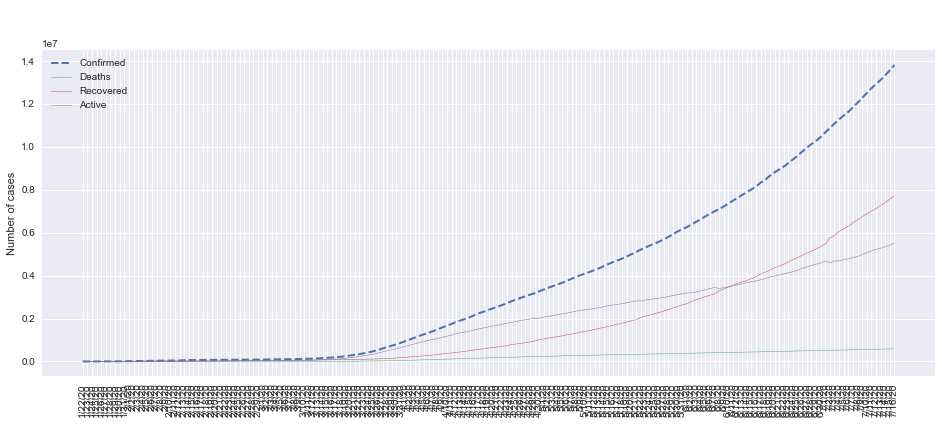

In [151]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set(yscale="linear")

sns.lineplot(x=covid_worldwide_confirmed.index, y=covid_worldwide_confirmed, sort=False, linewidth=2)
sns.lineplot(x=covid_worldwide_deaths.index, y=covid_worldwide_deaths, sort=False, linewidth=.5)
sns.lineplot(x=covid_worldwide_recovered.index, y=covid_worldwide_recovered, sort=False, linewidth=.5)
sns.lineplot(x=covid_worldwide_active.index, y=covid_worldwide_active, sort=False, linewidth=.5)

ax.lines[0].set_linestyle("--")
plt.suptitle("COVID-19 worldwide cases over the time", fontsize=16, fontweight='bold', color='white')
plt.title("(logarithmic scale)", color='white')

plt.xticks(rotation=90)
plt.ylabel('Number of cases')

ax.legend(['Confirmed', 'Deaths', 'Recovered', 'Active'])

plt.show()

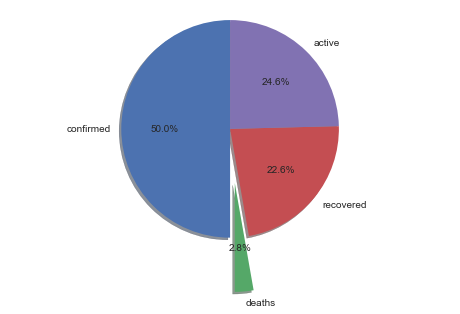

In [147]:
world_rate_df = pd.DataFrame({
    'confirmed': covid_worldwide_confirmed,
    'deaths': covid_worldwide_deaths,
    'recovered': covid_worldwide_recovered,
    'active': covid_worldwide_active
}, index=covid_worldwide_confirmed.index)

world_rate_df.tail()
world_rate_df.describe()

# Grab all averages of each and compare percentages

confirmed = world_rate_df['confirmed'].mean()
deaths = world_rate_df['deaths'].mean()
recovered = world_rate_df['recovered'].mean()
active = world_rate_df['active'].mean()

# # Pie chart # # 
labels =  ['confirmed', 'deaths', 'recovered', 'active']
sizes = [confirmed, deaths, recovered, active]
explode = (0, 0.5, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



In [148]:
# Calculate the recovery rate and add it to the world_rate_df 
recovery_rate = (world_rate_df['recovered'] / world_rate_df['confirmed'] * 100)
recovery_rate = ["{:.2f}%".format(val) for val in recovery_rate]
world_rate_df['Recovery Rate'] = recovery_rate

# Calculate the fatality rate and add it to the world_rate_df
fatality_rate = (world_rate_df['deaths'] / world_rate_df['confirmed'] * 100)
fatality_rate = ["{:.2f}%".format(val) for val in fatality_rate]
world_rate_df['Fatality Rate'] = fatality_rate

# Set the world_rate_df index to date 

world_rate_df['date'] = world_rate_df.index

world_rate_df.tail()

,confirmed,deaths,recovered,active,Recovery Rate,Fatality Rate,date
7/12/20,12910357,569128,7116957,5224272,55.13%,4.41%,7/12/20
7/13/20,13104391,573003,7257369,5274019,55.38%,4.37%,7/13/20
7/14/20,13324057,578646,7399474,5345937,55.53%,4.34%,7/14/20
7/15/20,13555532,584132,7559252,5412148,55.77%,4.31%,7/15/20
7/16/20,13805296,589911,7711525,5503860,55.86%,4.27%,7/16/20
